In [12]:
import csv
from transformers import AutoTokenizer
import numpy as np
from nltk.stem import WordNetLemmatizer
import re
import nltk
import os
nltk.download('stopwords')
nltk.download('wordnet')
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alena_khg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alena_khg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def preprocess_text(text):
    """
    Preprocess text by lowercasing, removing punctuation, numbers, stopwords, and lemmatizing.

    Args:
        text (str): Text to be preprocessed.

    Returns:
        str: Preprocessed text.
    """
    # Lowercasing
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenization
    words = text.split()

    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)


In [3]:
def format_number_to_string(number):
    """
    Formats a number into a 3-character string, adding leading zeros if necessary.

    Args:
        number (int): A number between 0 and 999.

    Returns:
        str: A string of length 3.
    """
    if not (0 <= number <= 999):
        raise ValueError("The number must be in the range 0 to 999.")

    return f"{number:03d}"

In [ ]:
def process_csv(file_path, l, with_period_id, with_event_type):
    """
    Process a CSV file to extract and tokenize data.

    Args:
        file_path (str): Path to the CSV file.
        l (int): Desired length of token arrays for the 'Tweet' column.
        with_period_id (bool): Whether to include the 'PeriodID' in the tweet text.
        with_event_type (bool): Whether to include 'EventType' in the output.

    Returns:
        tuple: A tuple of tokenized tweets (NumPy array), IDs, and EventTypes (if included).
    """
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    tweets, ids, event_types = [], [], []

    with open(file_path, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            try:
                tweet = row['Tweet']
                tweet_id = row['ID']
                period_id = int(row['PeriodID']) if with_period_id else None
                event_type = row['EventType'] if with_event_type else None

                if with_period_id:
                    tweet = f"{format_number_to_string(period_id)} {preprocess_text(tweet)}"
                else:
                    tweet = preprocess_text(tweet)

                tokens = tokenizer.encode(tweet, truncation=False, max_length=l, add_special_tokens=False)
                tweets.append(tokens)
                ids.append(tweet_id)
                if with_event_type:
                    event_types.append(event_type)
            except KeyError as e:
                print(f"Missing expected column in row: {row}")
                continue

    tweets = np.array(tweets, dtype=np.int32)
    return tweets, np.array(ids), np.array(event_types) if with_event_type else None

In [14]:
def read_csv(folder_path, l, with_period_id, with_event_type):
    """
    Read all CSV files in a folder and process them.

    Args:
        folder_path (str): Path to the folder containing the CSV files.
        l (int): Desired length of token arrays for the 'Tweet' column.
        with_period_id (bool): Whether to include the 'PeriodID' in the tweet text.
        with_event_type (bool): Whether to include 'EventType' in the output.

    Returns:
        tuple: A tuple of tokenized tweets (NumPy array), IDs, and EventTypes (if included).
    """
    all_tweets, all_ids, all_event_types = [], [], []

    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            tweets, ids, event_types = process_csv(file_path, l, with_period_id, with_event_type)
            all_tweets.append(tweets)
            all_ids.append(ids)
            if with_event_type:
                all_event_types.append(event_types)

    all_tweets = np.concatenate(all_tweets, axis=0)
    all_ids = np.concatenate(all_ids, axis=0)
    all_event_types = np.concatenate(all_event_types, axis=0) if with_event_type else None
    return all_tweets, all_ids, all_event_types

In [15]:
# function to count number of PAD token, tokenizer defined in the function
def count_pad_tokens(tokens, pad_token_id): 
    return tokens.count(pad_token_id)

In [16]:
folder_path = "../train_tweets/"
l = 32
with_period_id = True
with_event_type = True

tweets, ids, event_types = read_csv(folder_path, l, with_period_id, with_event_type)

# Save to .npy files
np.save("tweet_with_pID_train.npy", tweets)
np.save("id.npy", ids)
if event_types is not None:
    np.save("event_types.npy", event_types)

In [ ]:
# Save to .npy files in np_data folder
output_folder = "np_data"
os.makedirs(output_folder, exist_ok=True)

np.save(os.path.join(output_folder, "tweet_with_pID_train.npy"), tweets)
np.save(os.path.join(output_folder, "id_train.npy"), ids)
if event_types is not None:
    np.save(os.path.join(output_folder, "event_types.npy"), event_types)

In [ ]:
folder_path = "../train_tweets/"
l = 32
with_period_id = False
with_event_type = True

tweets, ids, event_types = read_csv(folder_path, l, with_period_id, with_event_type)

# Save to .npy files
np.save("tweet_without_pID_train.npy", tweets)

In [21]:
folder_path = "../eval_tweets/"
l = 32
with_period_id = True
with_event_type = False

tweets, ids, event_types = read_csv(folder_path, l, with_period_id, with_event_type)

# Save to .npy files
np.save(os.path.join(output_folder, "tweet_with_pID_eval.npy"), tweets)

In [22]:
folder_path = "../eval_tweets/"
l = 32
with_period_id = False
with_event_type = False

tweets, ids, event_types = read_csv(folder_path, l, with_period_id, with_event_type)

# Save to .npy files
np.save(os.path.join(output_folder, "tweet_without_pID_eval.npy"), tweets)

In [23]:
np.save(os.path.join(output_folder, "id_eval.npy"), ids)

In [ ]:
# Read all training files and concatenate them into one dataframe with Period Id in tweet tokens
# df_train_with_period_id = read_csv("../train_tweets/", True, True, 128)


In [ ]:
# df_train_without_period_id = read_csv("../train_tweets/", False, True, 128)

In [ ]:
# df_eval_with_period_id = read_csv("../eval_tweets/", True, False, 128)

In [ ]:
# df_eval_without_period_id = read_csv("../eval_tweets/", False, False, 128)

In [85]:
# define tokenizer and pad token id
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
pad_token_id = tokenizer.pad_token_id

In [ ]:
# count number of PAD tokens in tweets for each dataset and add this number as a new column
# df_train_with_period_id['PadTokensCount'] = df_train_with_period_id['Tweet'].apply(count_pad_tokens, args=(tokenizer, pad_token_id))

In [ ]:
# count number of PAD tokens in tweets for each dataset and add this number as a new column
# df_train_without_period_id['PadTokensCount'] = df_train_without_period_id['Tweet'].apply(count_pad_tokens, args=(tokenizer, pad_token_id))

In [ ]:
# count number of PAD tokens in tweets for each dataset and add this number as a new column
# df_eval_with_period_id['PadTokensCount'] = df_eval_with_period_id['Tweet'].apply(count_pad_tokens, args=(tokenizer, pad_token_id))

In [ ]:
# count number of PAD tokens in tweets for each dataset and add this number as a new column
# df_eval_without_period_id['PadTokensCount'] = df_eval_without_period_id['Tweet'].apply(count_pad_tokens, args=(tokenizer, pad_token_id))

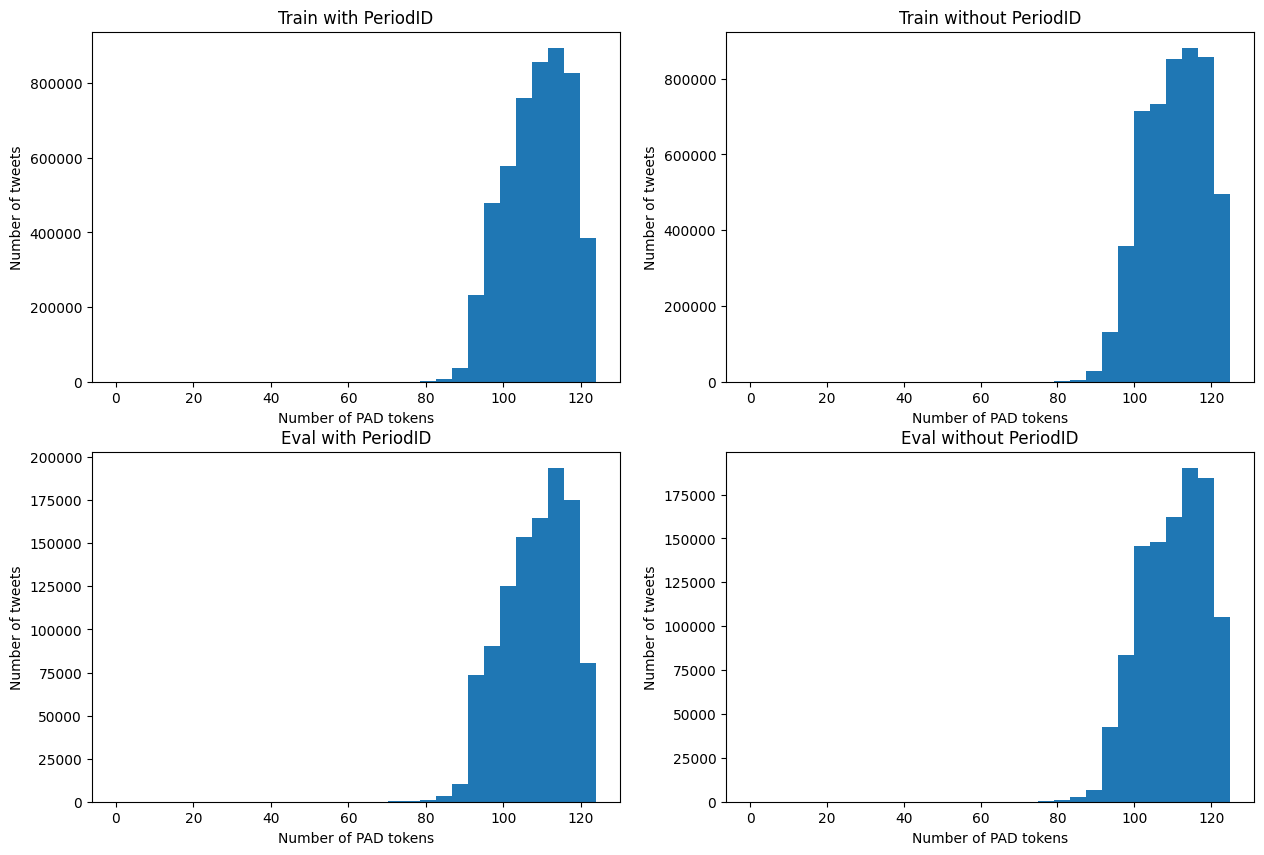

In [ ]:
# Make 4 histograms for each dataset with number of pad tokens
'''
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].hist(df_train_with_period_id['PadTokensCount'], bins=30)
axs[0, 0].set_title('Train with PeriodID')
axs[0, 0].set_xlabel('Number of PAD tokens')
axs[0, 0].set_ylabel('Number of tweets')

axs[0, 1].hist(df_train_without_period_id['PadTokensCount'], bins=30)
axs[0, 1].set_title('Train without PeriodID')
axs[0, 1].set_xlabel('Number of PAD tokens')
axs[0, 1].set_ylabel('Number of tweets')

axs[1, 0].hist(df_eval_with_period_id['PadTokensCount'], bins=30)
axs[1, 0].set_title('Eval with PeriodID')
axs[1, 0].set_xlabel('Number of PAD tokens')
axs[1, 0].set_ylabel('Number of tweets')

axs[1, 1].hist(df_eval_without_period_id['PadTokensCount'], bins=30)
axs[1, 1].set_title('Eval without PeriodID')
axs[1, 1].set_xlabel('Number of PAD tokens')
axs[1, 1].set_ylabel('Number of tweets')

plt.show()
'''

Text(0, 0.5, 'Number of tweets')

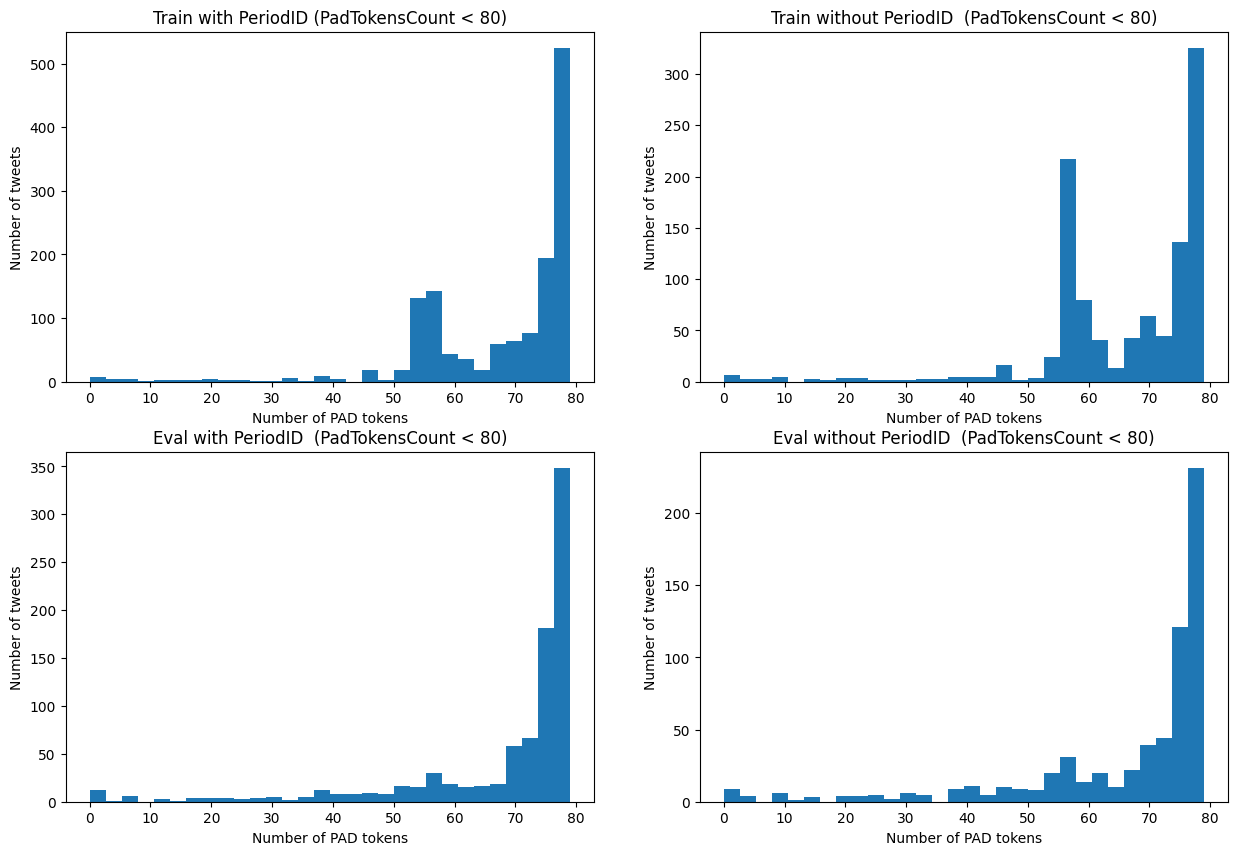

In [ ]:
# Make 4 histograms for each dataset with number of pad tokens for number of pad tokens <80
#add title that it is for number of pad tokens < 80
'''
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].hist(df_train_with_period_id[df_train_with_period_id['PadTokensCount'] < 80]['PadTokensCount'], bins=30)
axs[0, 0].set_title('Train with PeriodID (PadTokensCount < 80)')
axs[0, 0].set_xlabel('Number of PAD tokens')
axs[0, 0].set_ylabel('Number of tweets')

axs[0, 1].hist(df_train_without_period_id[df_train_without_period_id['PadTokensCount'] < 80]['PadTokensCount'], bins=30)
axs[0, 1].set_title('Train without PeriodID  (PadTokensCount < 80)')
axs[0, 1].set_xlabel('Number of PAD tokens')
axs[0, 1].set_ylabel('Number of tweets')

axs[1, 0].hist(df_eval_with_period_id[df_eval_with_period_id['PadTokensCount'] < 80]['PadTokensCount'], bins=30)
axs[1, 0].set_title('Eval with PeriodID  (PadTokensCount < 80)')
axs[1, 0].set_xlabel('Number of PAD tokens')
axs[1, 0].set_ylabel('Number of tweets')

axs[1, 1].hist(df_eval_without_period_id[df_eval_without_period_id['PadTokensCount'] < 80]['PadTokensCount'], bins=30)
axs[1, 1].set_title('Eval without PeriodID  (PadTokensCount < 80)')
axs[1, 1].set_xlabel('Number of PAD tokens')
axs[1, 1].set_ylabel('Number of tweets')
'''

In [ ]:
# 128 is current length right now
'''
print("Optimal length of token:")
print("Train with PeriodID", 128 - df_train_with_period_id['PadTokensCount'].quantile(0.05))
print("Train without PeriodID",128 - df_train_without_period_id['PadTokensCount'].quantile(0.05))
print("Eval with PeriodID",128 - df_eval_with_period_id['PadTokensCount'].quantile(0.05))
print("Eval without PeriodID",128 - df_eval_without_period_id['PadTokensCount'].quantile(0.05))
'''

Optimal length of token:
Train with PeriodID 33.0
Train without PeriodID 31.0
Eval with PeriodID 34.0
Eval without PeriodID 32.0


In [ ]:
# redefine df with new length
# df_train_with_period_id_new = read_csv("../train_tweets/", True, True, 32)

In [ ]:
# df_train_without_period_id_new = read_csv("../train_tweets/", False, True, 32)

In [ ]:
# df_eval_with_period_id_new = read_csv("../eval_tweets/", True, False, 32)

In [ ]:
# df_eval_with_period_id_new

,ID,Tweet
0,6_0,"[101, 2199, 2633, 2131, 2156, 2762, 2377, 1621..."
1,6_0,"[101, 2199, 19387, 2773, 15569, 4049, 13159, 2..."
2,6_0,"[101, 2199, 15677, 16216, 2099, 15088, 5603, 2..."
3,6_0,"[101, 2199, 16216, 2099, 1043, 3270, 102, 0, 0..."
4,6_0,"[101, 2199, 4049, 13159, 24665, 15979, 2674, 1..."
...,...,...
1072923,9_129,"[101, 14378, 19387, 1060, 3900, 1035, 23689, 2..."
1072924,9_129,"[101, 14378, 4558, 3532, 14372, 2474, 21254, 4..."
1072925,9_129,"[101, 14378, 2821, 6203, 6173, 3489, 8737, 357..."
1072926,9_129,"[101, 14378, 3599, 6583, 14713, 16558, 8649, 4..."


In [ ]:
# df_eval_without_period_id_new = read_csv("../eval_tweets/", False, False, 32)

In [ ]:
# count number of PAD tokens in tweets for each dataset and add this number as a new column
'''
df_train_with_period_id_new['PadTokensCount'] = df_train_with_period_id_new['Tweet'].apply(count_pad_tokens, args=(tokenizer, pad_token_id))
df_eval_without_period_id_new['PadTokensCount'] = df_eval_without_period_id_new['Tweet'].apply(count_pad_tokens, args=(tokenizer, pad_token_id))
df_train_without_period_id_new['PadTokensCount'] = df_train_without_period_id_new['Tweet'].apply(count_pad_tokens, args=(tokenizer, pad_token_id))
df_eval_with_period_id_new['PadTokensCount'] = df_eval_with_period_id_new['Tweet'].apply(count_pad_tokens, args=(tokenizer, pad_token_id))
'''

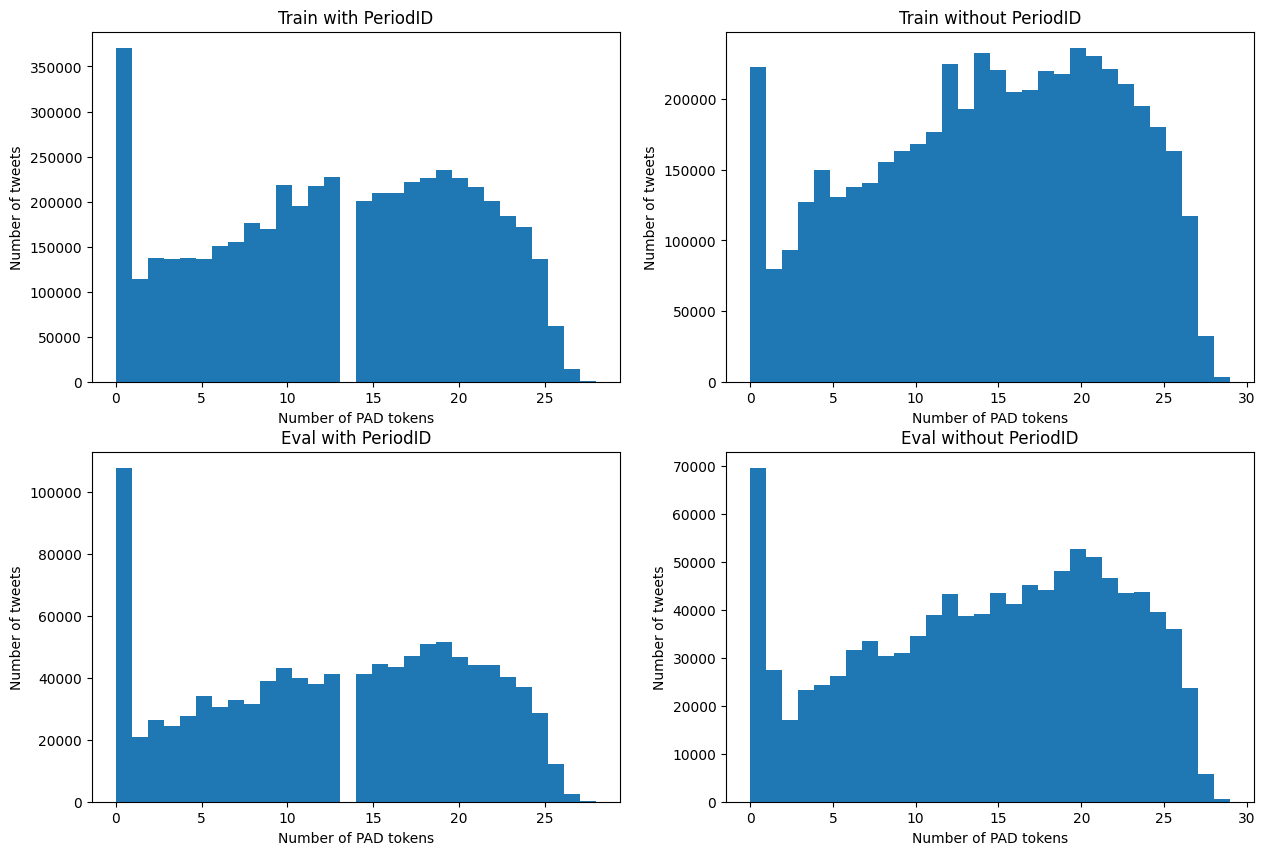

In [ ]:
# Make 4 histograms for each dataset with number of pad tokens
'''
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].hist(df_train_with_period_id_new['PadTokensCount'], bins=30)
axs[0, 0].set_title('Train with PeriodID')
axs[0, 0].set_xlabel('Number of PAD tokens')
axs[0, 0].set_ylabel('Number of tweets')

axs[0, 1].hist(df_train_without_period_id_new['PadTokensCount'], bins=30)
axs[0, 1].set_title('Train without PeriodID')
axs[0, 1].set_xlabel('Number of PAD tokens')
axs[0, 1].set_ylabel('Number of tweets')

axs[1, 0].hist(df_eval_with_period_id_new['PadTokensCount'], bins=30)
axs[1, 0].set_title('Eval with PeriodID')
axs[1, 0].set_xlabel('Number of PAD tokens')
axs[1, 0].set_ylabel('Number of tweets')

axs[1, 1].hist(df_eval_without_period_id_new['PadTokensCount'], bins=30)
axs[1, 1].set_title('Eval without PeriodID')
axs[1, 1].set_xlabel('Number of PAD tokens')
axs[1, 1].set_ylabel('Number of tweets')

plt.show()
'''